# Zelan Extended Essay


** To Dos**
~~1. Understand EEGDenoiseNet dataset structure (rows, columns)~~
~~2. Understand EEGDenoiseNet dataset's Github repository and sample codes, what a certain code file and line is for, and how I can use this as a baseline for my code.~~
~~3. Comprehend EOG orientation.~~
~~4. Create code to synthesize own 'dirty data'~~
5. Create an experimental setup.
&nbsp; 5.1. Read literature that used simulated EEG datasets (better if paper used EEGDenoiseNet specifically as well) and take note of how they used the dataset. This includes but is not limited to the ratio of the dataset used for training & testing, number of repetitions they used, performance metrics, and the model they used.
&nbsp; 5.2. Tabulate information about the paper (ex. Title, Link, Author, objective, dataset, method).
&nbsp; 5.3. Evaluate which method may work better for my objective.
~~6. Fully understand the role of SNR and how to use this in the experiment.~~
7. Create final code to create contaminated signal (with randomization considered)

## Questions (tbd/tba)
---
#### Preprocessing
1. Baseline frequency, notching, and Resampling were done to standardize the datasets among the EEG ground truth, EMG, and EOG artifacts. Why was the dataset resampled specifically to a 256Hz sampling rate? What makes this rate optimal for the dataset?
2. The dataset used ICA to achieve the EEG ground truth data. Will this affect my experimentation?
3. Since the dataset is based on real data but just artifically synthesized, can the dataset still be considered a simulated EEG Data?
&nbsp;--->YES. The dataset has a set ground truth, the new dataset to be used for experimentation is generated using controlled parameters and a given mathematical model (shown in section '2.2 Data Usage' of the paper), and the dataset is controlled and repeatable.
---
#### EOG data (Orientation: VEOG and HEOG)
**Why is there a vertical and horizontal EOG on the photo 'Example of Segments?' What do these imply?**

* Vertical EOG (VEOG) measures vertical eye movements.
* Horizontal EOG (HEOG) measures horizontal eye movements. The orientation of the electrodes and the placement of reference electrodes matter to accurately capture the eye movement signals.
* The EOG signal will show a positive or negative voltage deflection based on the direction of the eye movement and the electrode configuration. Thus, the orientation matters.

**How do I work with these orientations in the data?**

---
#### 1.4.2. SNR & RMS (Mathematics + Theory)
**How important is an adjustable SNR in this case? What specific role does SNR play in the dataset and the performance of the denoising algorithm to be used?**
&nbsp; --> Adjusting the SNR allows researchers to control the difficulty of the denoising task. Higher SNR levels (more signal, less noise) represent cleaner and easier-to-denoise signals, while lower SNR levels (weaker signal, more noise) introduce more challenging denoising scenarios. By training the algorithm on a dataset with adjustable SNR, the model can learn to handle both simple and complex denoising tasks, enhancing its generalization and adaptability to real-world EEG data.


**For my experimentation, how should I deal with the SNR? Should I pick a certain SNR (and how do I pick) or should I use varying SNRs, replicate, and tabulate the results?**
&nbsp; --> Look into related literatures' methods and see which one would work best for your case.




## I. Research Paper Review + Notes
**Title**:[EEGdenoiseNet: a benchmark dataset for deep learning solutions of EEG denoising](https://doi.org/10.1088/1741-2552/ac2bf8)
**Authors**:Haoming Zhang et al
**Link**: [https://github.com/ncclabsustech/EEGdenoiseNet](https://github.com/ncclabsustech/EEGdenoiseNet)
**File name**: EEG_all_epochs.npy
* Data stored in .npy files (Python numpy arrays)

### 1.1 Inclusions
* 4514 clean EEG segments
* 3400 ocular artifact segments (EOG)
* 5598 muscular artifact segments (EMG)

*Basically, the 4514 clean EEG segments will serve as my ground truth datasets. EOG and EMG are used to measure electrical brain activity or connection between the optics and heart activity respectively. EOG and EMG data were used by the researchers to create noise segments to be mixed with the 4514 clean EEG segments, acting as semi-synthetic data. Future researchers can then generate their own EOG-contaminated EEG, EMG-contaminated EEG, and EEG ground truth data*


### 1.2 Dataset Structure
* segmented into 2s epochs (each EEG recording is 2seconds)
* Number of rows represents number of samples
* all are resampled into 256Hz sampling rate. 512 columns because of the 2s duration per datapoint/row.
* The EEG data serves as the clean or ground truth data. The EEG, EMG, and EOG data are all separated to allow other researchers to synthesize their own mix of 'noise' (the emg or eog dataset) into their research. How to synthesize this dataset is documented in the research paper.

### 1.3 Dataset Collection Process
* 52 participants who performed both real and imaginary left and right hand movement task, with 64 channel EEG recorded simultaneously at 512 Hz sampling frequency.
![](64-channel-eeg.ppm)
* Downloaded EEG, EOG and EMG data from several publicly available data repositories which were published in previous studies (these studies cited in the paper)
* CLEAN EEG: Preprocessed and then separated into 2 second segments/epochs. 2 seconds. The researchers set the length of segments to 2s according to the previous knowledge of EEG signals. To add, it is difficult to obtain artifact-free EEG segments longer than 2 s due to the random eye blinks or movements.
* "To ensure the universality of this data set, we did not construct clean EEG signals with a specific number of channels due to the diversity of EEG caps, but constructed a dataset with single-channel EEG signal."

### 1.4 Preprocessing

1. *FREQUENCY RANGE OF INTEREST*: 1-80Hz; *data was filtered to include only these frequencies using band-pass filtering*
2. Notching at powerline frequency: a narrow band around the powerline frequency was filtered out to reduce any potential interference/noise caused by the powerline.
*A powerline is the frequency of the electrical power grid that supplies electricity. This powerline can generate electromagnetic fields that may interfere with the EEG signals.*
3. Re-sampling: From 512Hz, the dataset is re-sampled to a frequency of 256 Hz. It can be useful for standardizing the data or aligning it with other datasets.
4. EEG (Ground truth): Processed by ICLabel, a toolbox to remove EEG artifacts with independent component analysis (ICA)
5.
![](EEGDenoiseNet/1.2_eegdenoisenet_method.png)




### 1.5 Simulated Dataset Generation

#### 1.5.1 Linear Mixing
**Achieved by linearly mixing the pure EEG segments with EOG or EMG artifact segments, according to equation:**

$$y = x + λ · n$$
* $y$ is the simulated data (EEG mixed with artifact)
* $x$ denotes the clean EEG signal
* $n$ denotes the ocular or myogenic artifact
* $λ$ is a hyperparameter to control the signalto-noise ratio (SNR) in the contaminated EEG signal y

*Linear mixing refers to a process in which multiple signals are combined or mixed together in a linear manner. It involves adding or scaling individual signals and summing them to create a composite signal.*


#### 1.5.2. SNR & RMS (Mathematics + Theory)
$$SNR = 10log\frac{RMS(x)}{RMS(λ \times n)}$$

* The SNR formula quantifies the relative strength or quality of the desired signal compared to the level of background noise.
* Lower SNR means higher noise level means more complex for the algorithm to denoise the signal


**Root Mean Squared (RMS)** is used to quantify the overall magnitude or amplitude of a signal or a set of data points.
$$RMS(g) = \sqrt{\frac{1}{N}\sum\limits_{i=1}^N g_i^2}$$

\*basically the $i^{th}$ sample is squared. These are all summed up. The sum of these squares are multiplied by the reciprocal of the number of samples $\frac{1}{N}$. Finally, the value is square rooted\*

## II. Basic Data Exploration & Visualization

![](EEGDenoiseNet/1.2_eegdenoisenet_sample.png)

### 2.1 Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import random
import scipy

In [2]:
eeg = np.load('EEGDenoiseNet/EEG_all_epochs.npy')
print(f"------EEG-----\nSize: {eeg.size}\nRow count: {len(eeg)}\nColumn count: {len(eeg[0])}\nFirst Column: {eeg[:, 0]}\n\n")

emg = np.load('EEGDenoiseNet/EMG_all_epochs.npy')
print(f"------EMG(Heart)-----\nSize: {emg.size}\nRow count: {len(emg)}\nColumn count: {len(emg[0])}\nFirst Column: {emg[:, 0]}\n\n")

eog = np.load('EEGDenoiseNet/EOG_all_epochs.npy')
print(f"------EOG(Ocular)-----\nSize: {eog.size}\nRow count: {len(eog)}\nColumn count: {len(eog[0])}\nFirst Column: {eog[:, 0]}")

------EEG-----
Size: 2311168
Row count: 4514
Column count: 512
First Column: [184.5070843  171.96198926 229.56731921 ... 317.59704985 262.89154388
 216.07429779]


------EMG(Heart)-----
Size: 2866176
Row count: 5598
Column count: 512
First Column: [20245.96672667 23595.64263225 34991.76745427 ...  1490.61150022
   -38.705385    1260.54203952]


------EOG(Ocular)-----
Size: 1740800
Row count: 3400
Column count: 512
First Column: [  7.30828446  -1.68701752  12.4808031  ...   6.81209745 298.19922839
 -44.54226777]


***The code in the paper's github repo is written in MatLab. The following are my attempts of trying to comprehend what goes on with their code line by line***

**Understanding the dataset structure**
EEG is a timeseries data that measures the electrical activity of the brain thus it detects and records the voltage.

* 512 data points were recorded per second
* Each data point represents the measurement of the EEG signal's voltage at a specific moment in time.
* The number of rows represents the number of instances or samples in the dataset, NOT the duration. Thus, there are 4514 samples of EEG data.
* The duration of each EEG data po

#### 2.1.1 EOG Orientation

Extract the vertical and horizontal EOG signals:

***Note: Make sure you refer to the dataset documentation or any available information to identify the specific columns that correspond to VEOG and HEOG.***

For vertical EOG (VEOG), you need to select the corresponding channels or columns in the dataset that capture the vertical eye movements. The exact columns representing VEOG may depend on how the dataset was recorded or labeled.
For horizontal EOG (HEOG), similarly, you select the relevant channels or columns that capture the horizontal eye movements.


### 2.2 Data Visualization

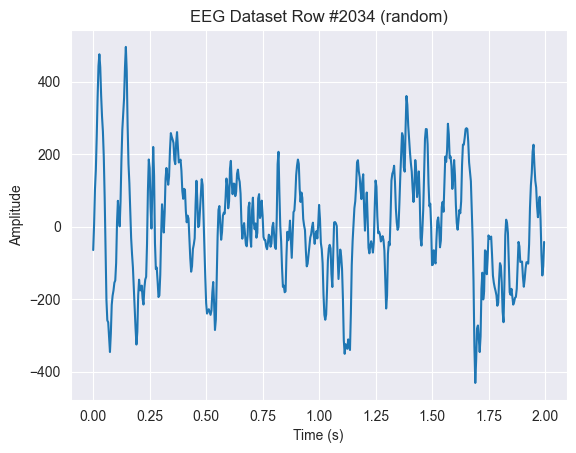

In [3]:
import matplotlib.pyplot as plt

eeg
num_rows, num_columns = eeg.shape

sampling_rate = 256  # Hz
duration = 2  # seconds
time = np.arange(0, duration, 1/sampling_rate)

#----PLOT FIRST ROW AS SAMPLE----
# plt.title('EEG Dataset - First Row')
# plt.plot(time, eeg[0])

#----PLOT RANDOM ROW AS SAMPLE-----
random_row_index = np.random.randint(num_rows) #produce random index or number
random_row = eeg[random_row_index] #extract row of that corresponding index
plt.plot(time, random_row)
plt.title(f'EEG Dataset Row #{random_row_index} (random)')


#----PLOT ALL-----
# for i in range(num_rows):
#     plt.plot(time, eeg[i])
# plt.title('EEG Dataset')

# Add labels and title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

***The code in the paper's github repo is written in MatLab. The following are my attempts of trying to comprehend what goes on with their code line by line***

**Understanding the dataset structure**
EEG is a timeseries data that measures the electrical activity of the brain thus it detects and records the voltage.

* 512 data points were recorded per second
* Each data point represents the measurement of the EEG signal's voltage at a specific moment in time.
* The number of rows represents the number of instances or samples in the dataset, NOT the duration. Thus, there are 4514 samples of EEG data.
* The duration of each EEG data po

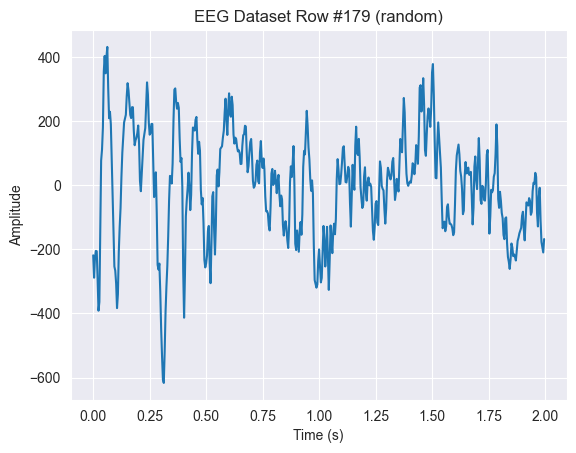

In [4]:
import matplotlib.pyplot as plt

eeg
num_rows, num_columns = eeg.shape

sampling_rate = 256  # Hz
duration = 2  # seconds
time = np.arange(0, duration, 1/sampling_rate)

#----PLOT FIRST ROW AS SAMPLE----
# plt.title('EEG Dataset - First Row')
# plt.plot(time, eeg[0])

#----PLOT RANDOM ROW AS SAMPLE-----
random_row_index = np.random.randint(num_rows) #produce random index or number
random_row = eeg[random_row_index] #extract row of that corresponding index
plt.plot(time, random_row)
plt.title(f'EEG Dataset Row #{random_row_index} (random)')


#----PLOT ALL-----
# for i in range(num_rows):
#     plt.plot(time, eeg[i])
# plt.title('EEG Dataset')

# Add labels and title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

**Creating a function to visualize a randomized row of data for each eeg, emg, and eog datasets**

In [5]:
def plot_random_row(dataset, title:str):
    num_rows, num_columns = dataset.shape
    sampling_rate = 256  # Hz
    duration = 2  # seconds
    time = np.arange(0, duration, 1/sampling_rate)

    #----PLOT RANDOM ROW AS SAMPLE-----
    random_row_index = np.random.randint(num_rows) #produce random index or number
    random_row = dataset[random_row_index] #extract row of that corresponding index
    plt.plot(time, random_row)
    plt.title(f'{title} Dataset Row #{random_row_index} (random)')
    return plt.show()

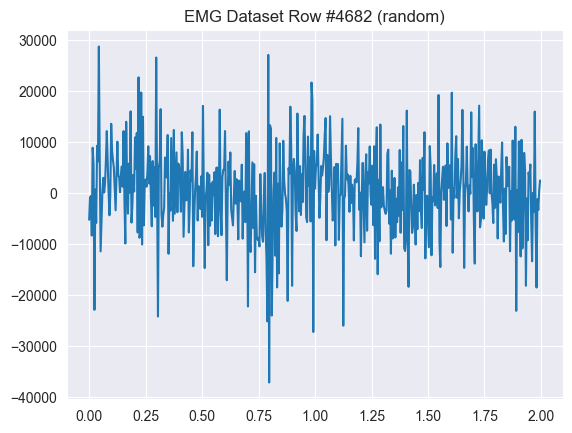

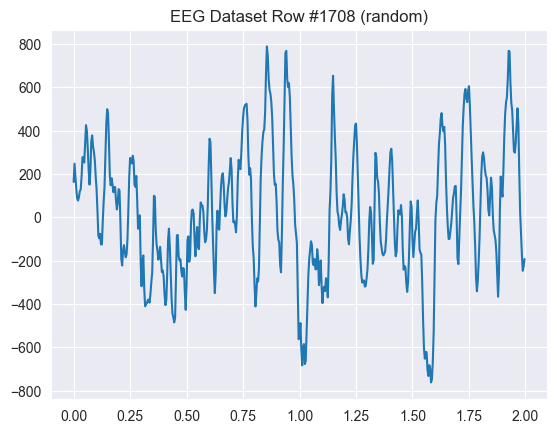

In [6]:
plot_random_row(emg,'EMG')
plot_random_row(eeg,'EEG')

#### 2.3 Contaminated Data Generation (sample)

**SNR**
The paper also states that "According to previous studies, the SNR of EEG contaminated by ocular artifacts is usually ranging from −7 to 2 dB, while the SNR of EEG contaminated by myogenic artifacts are between −7 and 4 dB."

With this, I can set line 8 to: ```snr = np.random.uniform(-7, 2)``` or pick an snr of my choice.

Remember that ***lower SNR means higher noise level*** making it more complicated for a certain algorithm to denoise.

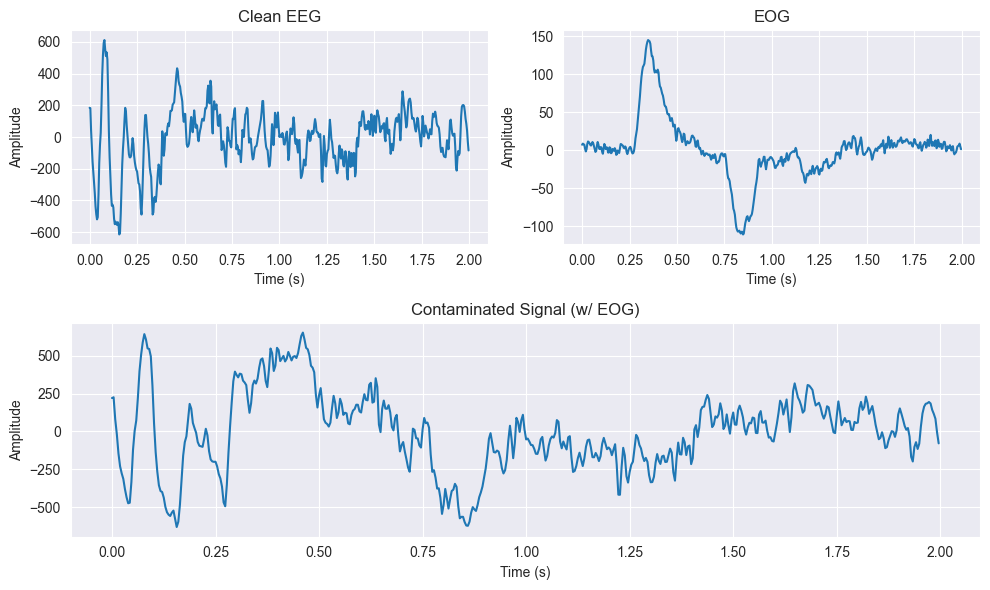

In [7]:
# Load the clean EEG, EOG, and EMG data from .npy files
clean_eeg_data = eeg[:3400] #NEed this part to randomly pick 3400 rows instead of just the first 3400 rows.
eog_data = eog
emg_data = emg

# Set the SNR hyperparameter (λ) to control the signal-to-noise ratio
snr = 5  # Adjust this value as per your requirement

# Generate contaminated signal
contaminated_signal = clean_eeg_data + snr * eog_data  # You can also add EMG artifacts if desired

# Plot the clean EEG, EOG, and contaminated signals for visualization
import matplotlib.pyplot as plt

sampling_rate = 256  # Hz
duration = 2  # seconds
time = np.arange(0, duration, 1/sampling_rate)

plt.figure(figsize=(10, 6))

# Plot clean EEG
plt.subplot(2, 2, 1)
plt.plot(time, clean_eeg_data[0])  # Replace '0' with the desired segment or row from the clean EEG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Clean EEG')

# Plot EOG
plt.subplot(2, 2, 2)
plt.plot(time, eog_data[0])  # Replace '0' with the desired segment or row from the EOG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EOG')

# Plot contaminated signal
plt.subplot(2, 1, 2)
plt.plot(time, contaminated_signal[0])  # Replace '0' with the desired segment or row from the contaminated signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Contaminated Signal (w/ EOG)')

plt.tight_layout()
plt.show()


## III. Related Literatures' Methods

| Authors + Year           | Title | Objective | Dataset                                                                                                                                                                                                                                                                                                                              | Methods                                                                                                                                                                                                                        | Insights |
|--------------------------|---------------------|-----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|
| Haoming Zhang et al 2021 | EEGdenoiseNet: a benchmark dataset for deep learning solutions of EEG denoising | Test dataset on different denoising methods (EMD, Filter, FCNN, Simple CNN, Complex CNN, RNN) | During semi-synthetic data generation, they created 2 sets: EOG-affected and EMG-affected datasets. From these 2 sets, they created more datasets with 10 varying SNR levels, resulting to 10 different sub dataset to be tested on. For each sub datasets, 80% is used as training set, 10% as validation set, and 10% as test set. | Performance metrics: RRMSE, CC, and other complicated metrics; Plots: performace plots (best & worst performing for each 5 ML model), MSE loss function plot, RRMSE plot, performance at 10 SNR levels, Table of power ratios. | / |
| Gan Wang et al 2014 | The Removal of EOG Artifacts from EEG Signals Using Independent Component Analysis and Multivariate Empirical Mode Decomposition | Proposed an algorithhm IMEMD which consists of 5 steps | Tested on synthetic data (90 groups of EOG + 1 EEG using MATLAB; 5x1600 matrix size each group;) and then on actual 3 human subjects' EEG recordings                                                                                                                                                                                 | SNR & MSE were used as performance metrics                                                                                                                                                                                     | / |
| Laurent Albera et al 2012 | ICA-based EEG denoising: a comparative analysis of 15 methods | Determine whether 15 specifical ICA methods are better suited in terms of performance and computational complexity | scalp-EEG data acquired from 32 electrodes; 256Hz                                                                                                                                                                                                                                                                                    | 15 ICA methods were briefly described and then studied based on numerical and performance complexity (Normalized MSE, Effect of SNR)                                                                                           | / |
| Doha Safieddine et al 2012 | Removal of muscle artifact from EEG data: comparison between stochastic (ICA and CCA) and deterministic (EMD and wavelet-based approaches) | / | Simulated & Real MULTI-CHANNEL data; Sampling Freq: 256Hz;                                                                                                                                                                                                                                                                           | Did 50 trials and calculated the average normalized MSE; Since it's multi-channel, they also did a method to see the effect of source localization of the algorithm on the dataset.                                            | / |

### 3.4 Doha Safieddine et al 2012
**Title**: Removal of muscle artifact from EEG data: comparison between stochastic (ICA and CCA) and deterministic (EMD and wavelet-based) approaches
**Objective**:

**Dataset**
* 8,192 samples which correspond to 32 seconds.
* multi-channel (32) EEG data
----*Simulated data*----
* generated using a realistic head model representing the brain, skull, and scalp.
* 50 epochs of EEG muscle activity were extracted from real 32-channel EEG data. Each muscle activity was then normalized with respect to the channel showing the maximal power.
* Different levels of amp of muscle activity were added to simulate spiky activity and get noisy simulated signals with SNR values of -30, -25, -20, -15, -10, and -5dB.

----*Real data*----
* the algoritms were applied to denoise interictal spikes in a 40-year-old patient ("Patient P") suffering from a drug-resistant partial epilepsy since age 26.
* Scal EEG was acquired from 32 electrodes (19-20, 10-20 standard + a few others); !!!SIMILAR TO PAPER 3.3!!!!
* Sampling frequency of 256Hz + [0.3-100Hz] band pass filter.

**Methods**:
* *Performance Criteria*: Normalized MSE.
* 50 trials.
* The average NMSE of 50 trials for each algorithm was calculated.

**Results**
* 2T-emd performs better than certain algorithm for very low SNR (-30dB)
* etc etc

### 3.1 Haoming Zhang et al 2021
**Title**: EEGdenoiseNet: a benchmark dataset for deep learning solutions of EEG denoising
**Objective**: Test dataset on different denoising methods
**Dataset** EEGDenoiseNet
**Methods**:
1. *Semi-synthetic data generation*
    * Generate 2 types of contaminated signals: ocular artifact contaminated (3400) and myogenic artifact contaminated (5598).
    * From this contaminated data, 80% is used for generating the training set, 10% for generating the validation set, and 10% for generating the test set.
    * They decided on 10 different SNR levels (−7, −6, −5, −4, −3, −2, −1, 0, 1, 2 dB). This procedure led to using the same randomly 3400 generated rows of EEG and EOG artifact segments into 10 different sub datasets.
2. Created benchmark algorithms to test the dataset on (FCNN, Simple CNN, Complex CNN, RNN).
3. Learning process (They used Machine Learning algorithms that's why this step was needed)
4. Performance evaluation
    * RRMSE, CC, and other complicated metrics.
5. Show results
    * Performance plot
        * They plotted the Best and Worst result for each model (FCNN, Simple CNN, Complex CNN, RNN)
        * There are 2 plots for each: Amp-Time Plot, and Power spectral density (PSD Db-Frequency Hz)
        * Colors: orange(ground-true), green(noisy) and blue(cleaned by model); thus to visually see how the model performed, check how well the orange and blue lines are aligned.
    * MSE loss function plot
    * Performance at 10 SNR levels
    * RRMSE plots
    * Table of power ratios.

### 3.2 Gang Wang et al 2014
**Title**: The Removal of EOG Artifacts from EEG Signals Using Independent Component Analysis and Multivariate Empirical Mode Decomposition
**Objective**: Proposed an algorithhm IMEMD which consists of 5 steps
**Remarks**:
* Used 200Hz sampling rate for Simulated data but unclear for real data. This may affect the performance of the algorithm.


**Dataset**:
The paper used 2 datasets: simulated and then real EEG data.


----*Simulated EEG Data*----
* Both EEG and EOG signals were obtained in MATLAB.
* Sampling rate: 200Hz;
* 90 groups of pure EEG signals (matrix B size 5x1600 each).
* 1 group of simulated EOG (matrix A size 5x1600).
* artifact-contamined EEG signals were then mixed by mixing matrix A w/ matrix B: $C(i,:) = A(i,:)+λ*B(i,:)\in{1,2,3,4,5}$


----*Real EEG Data*----
* 3 healthy human male subjects (mean age 23, range 22-24y.o.)
* 32-scalp electrodes according to the standard 10-20 system.
* Position/Channel Cz at the top of the head was used as the reference electrode (Provide a stable electrical reference point against which the activity measured by other electrodes can be compared).
    * provide a stable electrical reference point against which the activity measured by other electrodes can be compared.
* 30 EEG segments contaminated by EOAs were cut off from each subject and the length of EEG segments ranged from 3 to 8 s.


**Methods**

![](rrl/gwang2014_fig1.png)

1. Multichannel EEG signals are decomposed using the MEMD (Multivariate Empirical Mode Decomposition) technique. This decomposition produces multiple multivariate intrinsic mode functions (MIMFs) that capture different components of the original EEG signals.

2. Among the MIMFs obtained in the previous step, those specifically related to eye movement artifacts (EOAs) are selected. These selected MIMFs are then used to reconstruct the EOG (electrooculogram)-related signals. The remaining MIMFs, which do not contain EOA-related information, are retained.
    * The signal underwent Wavelet Transform to achieve a time-frequency representation of the signal. Ocular artifacts are characterized by abnormal burst of high-energy in low-frequency. By comparing the TFR of the EOG reference signal with the TFRs of other EEG signals, the researchers could identify the multivariate intrinsic mode functions (MIMFs) that have similar time-frequency characteristics to the EOG reference signal. These selected MIMFs are believed to be linked to the artifacts caused by eye movements.

3. Independent Component Analysis (ICA) is applied to the EOG-related signals obtained in the previous step. This step aims to extract multiple independent components (ICs) that represent different sources or origins of the EOG-related signals.

4. The ICs that are linked to EOG activity are identified and removed. These ICs are considered to be responsible for the eye movement artifacts, and eliminating them helps in isolating the clean EEG signals.

5. Finally, the inverse transforms of ICA and MEMD are performed to reconstruct the clean EEG signals without eye movement artifacts. This step combines the retained MIMFs (which do not contain EOA-related information) with the remaining ICs after EOG-linked ICs have been rejected, resulting in the desired artifact-free EEG signals.




**Results**
* Higher SNR after denoising means it removed the most artifacts. In this case, MMEMD obtained the highest SNR.
*  MSE represents the average squared difference between the estimated values (in this case, the denoised EEG signal) and the true values (the original clean EEG signal)
    * MSE=
* MMEMD obtained the least MSE and thus reserved the most useful EEG information among four kinds of methods.

### 3.3 Laurent Albera et al 2012
**Title**: ICA-based EEG denoising: a comparative analysis of fifteen methods
**Objective**: Determine whether 15 specifical ICA methods are better suited in terms of performance and computational complexity

**Dataset**
* During video-EEG monitoring, scalp-EEG data were acquired from 32 electrodes (19-20 standard 10-20 electrodes plus additional electrodes at FC1, FC2, FC5, FC6, CP1, CP2, CP5, FT9, FT10, P9, P10 and POZ)(Albera et al., 2012, p. 20)
* Sampling Frequency: 256Hz
* Source localization

* **Methods**:
1. The 15 ICA methods are briefly described and then studied based on performance and numerical complexity.
2. Performance metrics: Normalized MSE, Effect of SNR,